In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt
#战置全局字体大小为12
plt.rcParams['font.size'] = 11
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
# 设置全局字体
plt.rcParams['font.family']=' Times New Roman, SimSun'# 设置字体族，中文为SimSun，英文为Times New Roman
plt.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix
import warnings
# 禁用所有警告
warnings.filterwarnings("ignore")

In [28]:
'''很奇怪，参数和数据都没有改动，但是clustermap画出来的图长得不一样了'''

epsilon = 1e-10
core = "core"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1, 50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(
        r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s\top10_%s_lcczscore.csv" % (trait, core))
    df = df.sort_values("tissue")
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"]
alltraits_significant_T = alltraits_significant.T

'''计算每两列(性状）之间的余弦相似度'''
cosine_similarities = pd.DataFrame(index=alltraits_significant.columns, columns=alltraits_significant.columns)
for col1 in alltraits_significant.columns:
    for col2 in alltraits_significant.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant[col1], alltraits_significant[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1
# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)

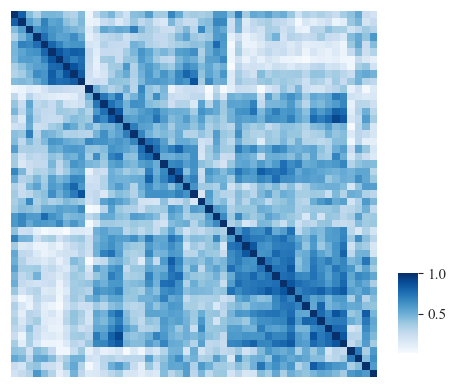

In [33]:

g = sns.clustermap(cosine_similarities, cmap='Blues', 
                   figsize=(4, 4), linewidths=0,
                   xticklabels=False, yticklabels=False,
                   dendrogram_ratio=(0.001, 0.001),
                   method='complete', metric='cosine',
                   cbar_pos=(1.01, 0.1, 0.05, 0.2),
                   cbar_kws={"shrink": 0.2} , # 调整颜色条的长度
                   center=0.5)
g.savefig(r"E:\00_CeSOP\plot\figures\31.png",dpi=1000) 

In [41]:
cosine_similarities_T = cosine_similarities.T

'''提取聚类结果'''
# 计算余弦距离矩阵
cosine_distance = pdist(cosine_similarities_T, metric='cosine')  # Transpose to calculate column distances
# 生成层次聚类
linkage_matrix = sch.linkage(cosine_distance, method='complete')
# 划分簇，设置簇数为3
array = cosine_similarities_T.iloc[:, 0:-1].to_numpy()
cluster_assignments = sch.fcluster(linkage_matrix, t=2, criterion='maxclust')
# 添加簇分配结果到 DataFrame
cosine_similarities_T['Cluster'] = cluster_assignments

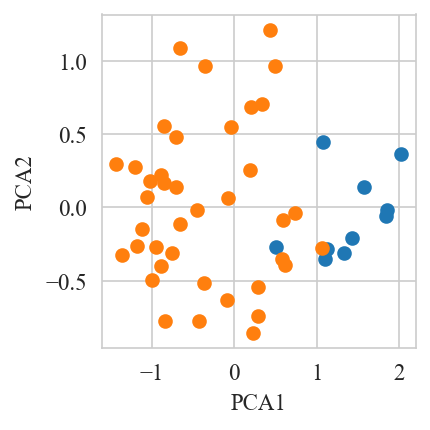

In [23]:
'''如何验证组织特异性将性状聚为两簇'''
'''思路一：将性状的组织特征向量降到二维，这两簇的可视化有显著差异'''
from sklearn.decomposition import PCA
# 应用PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(cosine_similarities_T.iloc[:, :-1])
y = cosine_similarities_T.iloc[:, -1]  # 类别标签

plt.figure(figsize=(3, 3),dpi = 150)
# 绘制降维后的数据
for label in np.unique(y):
    plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=f'Group {label}')
    
plt.xlabel('PCA1')
plt.ylabel('PCA2')
# plt.title('PCA Result')
plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\plot\figures\32.png",dpi=1000, bbox_inches='tight')
plt.show()


In [35]:
'''将CeSOP方法与ldsc发现的性状遗传关联做散点图 '''
ct_traits = pd.read_csv(r"E:\00_CeSOP\results\ldsc_rg\cesop\celltypes\edges.csv")[["Node1","Node2","value"]]
t_traits = pd.read_csv(r"E:\00_CeSOP\results\ldsc_rg\cesop\tissues\edges.csv")[["Node1","Node2","value"]]
ldsc_traits = pd.read_csv(r"E:\00_CeSOP\results\ldsc_rg\ldsc\edges.csv")[["Node1","Node2","value"]]

ct_traits = ct_traits.sort_values(["Node1","Node2"]).reset_index()
t_traits = t_traits.sort_values(["Node1","Node2"]).reset_index()
ldsc_traits = ldsc_traits.sort_values(["Node1","Node2"]).reset_index()

df = pd.concat([ct_traits, t_traits,ldsc_traits], axis = 1, ignore_index=True)
df_results = df.iloc[:,[1,2,3,7,11]]
df_results.columns = ["Node1","Node2","Corr_tissues","Corr_celltypes","Ldsc_rg"]

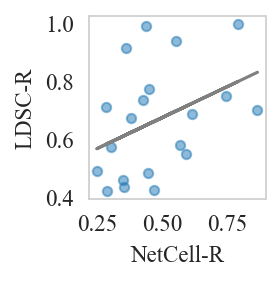


余弦相似度:
0.9422278679033211


In [39]:
'''只画出LDSC高遗传关联的散点'''
from scipy import stats

df_results_filtered = df_results[df_results["Ldsc_rg"]>0.4]
x = df_results_filtered["Corr_tissues"]
y = df_results_filtered["Ldsc_rg"]

# 计算线性回归
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df_results_filtered["Corr_tissues"], df_results_filtered["Ldsc_rg"])
line1 = slope1 * df_results_filtered["Corr_tissues"] + intercept1

fig = plt.figure(figsize = (2,2),dpi = 150)
plt.scatter(x,y,s = 20,alpha = 0.5)
plt.plot(df_results_filtered["Corr_tissues"], line1, color='grey')
plt.xlabel("NetCell-R")
plt.ylabel("LDSC-R")
plt.grid(False)
plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\plot\figures\33.png",dpi=1000, bbox_inches='tight')
plt.show()


from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(df_results_filtered["Corr_tissues"].values.reshape(1, -1), df_results_filtered["Ldsc_rg"].values.reshape(1, -1))[0, 0]
print("\n余弦相似度:")
print(cosine_sim)

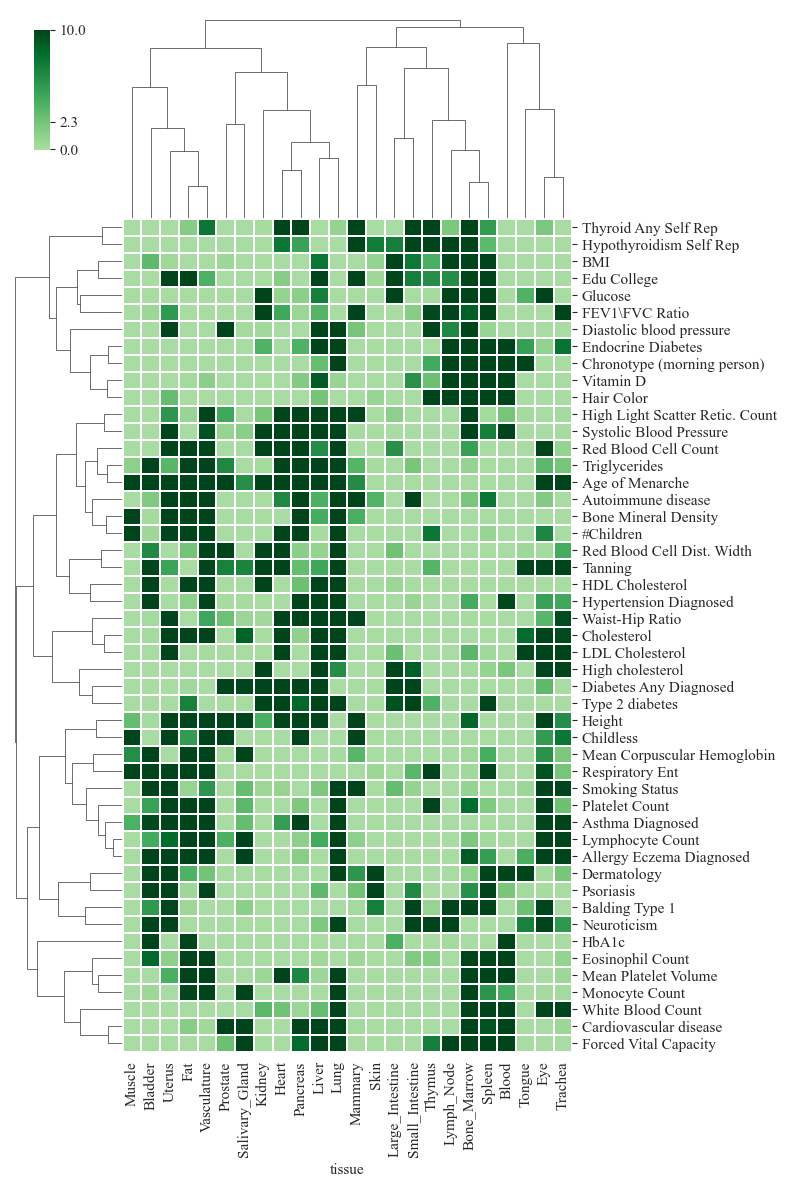

In [43]:
'''根据组织特异性对性状进行聚类，并输出聚类结果'''
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

epsilon = 1e-10
core = "core"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1, 50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(
        r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s\top10_%s_lcczscore.csv" % (trait, core))
    df = df.sort_values("tissue")
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"]

'''层次聚类'''
alltraits_significant_T = alltraits_significant.T
x = -np.log10(0.005 + epsilon)
cg = sns.clustermap(alltraits_significant_T, cmap='Greens', figsize=(8, 12), linewidths=0.01,
                    xticklabels=True, yticklabels=True,
                    method='complete', metric='cosine',
                    cbar_pos=(0.05, 0.87, 0.02, 0.1),
                    cbar_kws={'ticks': [0, x, 10]},
                    center=x)  #行是组织，列是性状
# plt.show()

'''计算每两列(性状）之间的余弦相似度'''
cosine_similarities = pd.DataFrame(index=alltraits_significant.columns, columns=alltraits_significant.columns)
for col1 in alltraits_significant.columns:
    for col2 in alltraits_significant.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant[col1], alltraits_significant[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1
# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)
# 转换为一维数组，提取两两之间的相关系数
correlation_list = []
rows, cols = cosine_similarities.shape
for i in range(rows):
    for j in range(i + 1, cols):
        correlation_list.append(
            (cosine_similarities.index[i], cosine_similarities.columns[j], cosine_similarities.iat[i, j]))
# 转换为DataFrame并显示
correlation_df = pd.DataFrame(correlation_list, columns=['Node1', 'Node2', 'value'])
# correlation_df.to_csv(r"E:\00_CeSOP\results\temp\cytoscape\traits_cosine_similarity_for_tissues\edges.csv", index=None)

'''提取聚类结果'''
# 计算余弦距离矩阵
cosine_distance = pdist(alltraits_significant_T, metric='cosine')  # Transpose to calculate column distances
# 生成层次聚类
linkage_matrix = sch.linkage(cosine_distance, method='complete')
# 划分簇，设置簇数为2
array = alltraits_significant_T.iloc[:, 0:-1].to_numpy()
cluster_assignments = sch.fcluster(linkage_matrix, t=2, criterion='maxclust')
# 添加簇分配结果到 DataFrame
alltraits_significant_T['Cluster'] = cluster_assignments

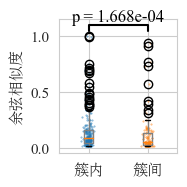

In [44]:
from scipy.stats import mannwhitneyu
'''思路二：簇内和簇间的ldsc 遗传相关性有显著差异'''
ldsc_traits = pd.read_csv(r"E:\00_CeSOP\results\ldsc_rg\ldsc\edges.csv")[["Node1","Node2","value"]]

intra_corr = []
inter_corr = []
for i in range(1, 3):
    group1 = list(alltraits_significant_T[alltraits_significant_T["Cluster"] == i].index)
    filtered_df = ldsc_traits[ldsc_traits['Node1'].isin(group1) & ldsc_traits['Node2'].isin(group1)]
    intra_corr.extend(list(filtered_df[filtered_df['value']>0.01]['value']))  #簇内

    filtered_df1 = ldsc_traits[ldsc_traits['Node1'].isin(group1) & ~ldsc_traits['Node2'].isin(group1)]
    inter_corr.extend(list(filtered_df1[filtered_df1['value']>0.01]['value']))  # 簇间

corr_list = [intra_corr, inter_corr]
# 散点箱线图
# 设置图形大小
plt.figure(figsize=(2, 2))
# 创建箱线图
box = plt.boxplot(corr_list, boxprops=dict(color='grey'), whiskerprops=dict(color='grey'))
# 绘制散点图
for i, d in enumerate(corr_list, 1):
    y = d
    x = np.random.normal(i, 0.04, size=len(y))  # 在x轴位置上添加一些随机抖动
    plt.scatter(x, y, alpha=0.6, s=0.2)

from scipy.stats import ttest_ind
# 计算 p 值
stat, p_value = mannwhitneyu(intra_corr, inter_corr, alternative='two-sided')
# t_stat, p_value = ttest_ind(intra_corr, inter_corr)
# 在箱体之间添加标示线和 p 值
x1, x2 = 1, 2
y, h, col = max(max(intra_corr), max(inter_corr)) + 0.05, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * .5, y + h, f"p = {p_value:.3e}", ha='center', va='bottom', color=col, fontsize=12)

# 设置自定义横轴坐标值和标签
custom_ticks = [1, 2]  # 自定义的横轴坐标值
custom_labels = ["簇内", "簇间"]  # 对应的标签
plt.xticks(custom_ticks, custom_labels)
plt.yticks([0,0.5,1])
plt.ylabel("余弦相似度")

plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\plot\figures\34.png",dpi=1000)
plt.show()

No NaN or inf values in the data.
Silhouette Score: 0.13972479757968695
Calinski-Harabasz Score: 4.284599127703861


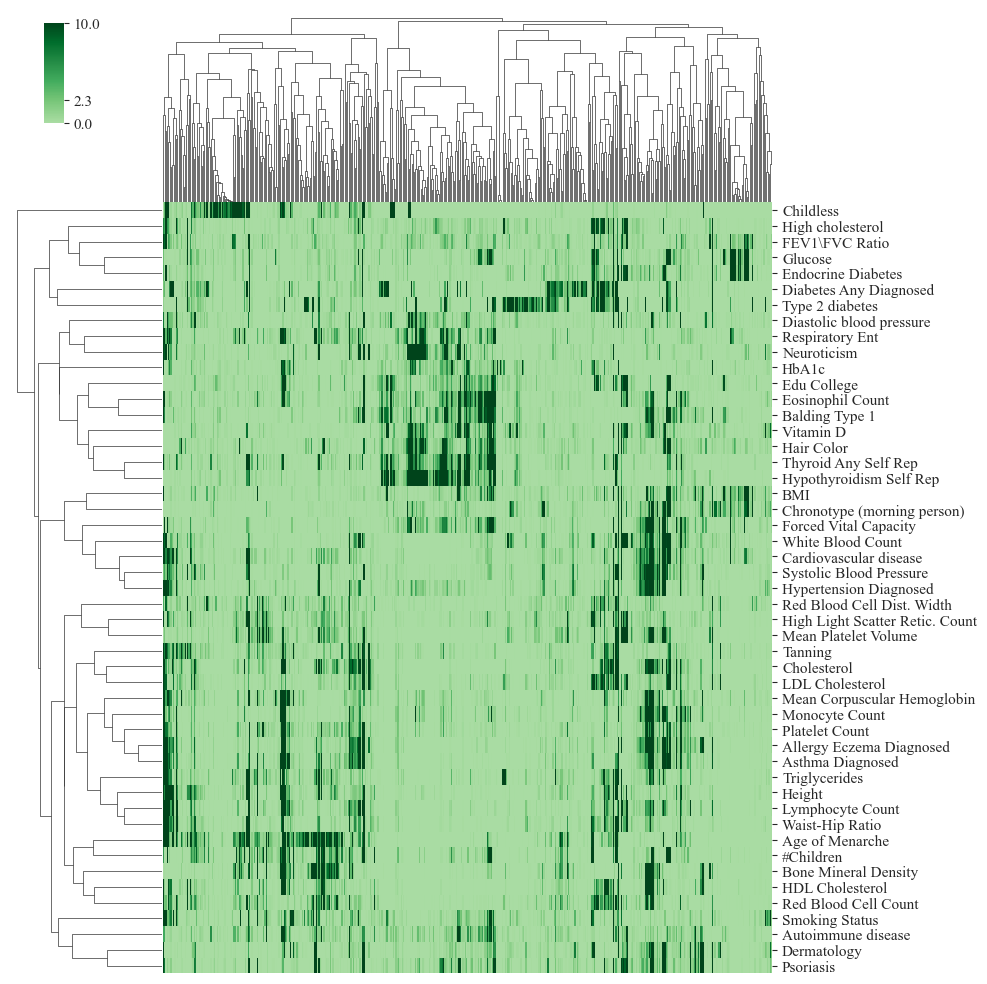

In [46]:
'''根据细胞类型特异性对性状进行聚类，并输出聚类结果'''

traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1,50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values(["tissue","celltype"])  
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"] + "---" + df["celltype"]
# 处理NaN和inf值
alltraits_significant = alltraits_significant.replace([np.inf, -np.inf], np.nan).dropna()
# 检查是否有NaN或inf值
if alltraits_significant.isnull().values.any():
    print("Data contains NaN or inf values.")
else:
    print("No NaN or inf values in the data.")

'''层次聚类'''
alltraits_significant_T = alltraits_significant.T
x = -np.log10(0.005 + epsilon)
cg = sns.clustermap(alltraits_significant_T, cmap='Greens', 
                    yticklabels=True, xticklabels=False,
                    method='weighted', metric='correlation',
                    # method='complete', metric='cosine',
                    cbar_pos=(0.05, 0.87, 0.02, 0.1),
                    cbar_kws={'ticks': [0, x, 10]},
                    center=x)  #行是组织，列是性状
# plt.show()

'''计算每两列(性状）之间的余弦相似度'''
cosine_similarities = pd.DataFrame(index=alltraits_significant.columns, columns=alltraits_significant.columns)
for col1 in alltraits_significant.columns:
    for col2 in alltraits_significant.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant[col1], alltraits_significant[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1
# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)
# 转换为一维数组，提取两两之间的相关系数
correlation_list = []
rows, cols = cosine_similarities.shape
for i in range(rows):
    for j in range(i + 1, cols):
        correlation_list.append(
            (cosine_similarities.index[i], cosine_similarities.columns[j], cosine_similarities.iat[i, j]))
# 转换为DataFrame并显示
correlation_df = pd.DataFrame(correlation_list, columns=['Node1', 'Node2', 'value'])
# correlation_df.to_csv(r"E:\00_CeSOP\results\temp\cytoscape\traits_cosine_similarity_for_celltypes\edges.csv", index=None)

'''提取聚类结果'''
# 计算余弦距离矩阵
cosine_distance = pdist(alltraits_significant_T, metric='cosine')  # Transpose to calculate column distances
# 生成层次聚类
linkage_matrix = sch.linkage(cosine_distance, method='complete')
# 划分簇，设置簇数为3
array = alltraits_significant_T.iloc[:, 0:-1].to_numpy()
# best_n_cluster = bestNclusters(linkage_matrix,array)
# print(best_n_cluster)
# cluster_assignments = sch.fcluster(linkage_matrix, t=best_n_cluster, criterion='maxclust')
# cluster_assignments = sch.fcluster(linkage_matrix, t=10, criterion='maxclust')
cluster_assignments = sch.fcluster(linkage_matrix, t=4, criterion='maxclust')
# 添加簇分配结果到 DataFrame
alltraits_significant_T['Cluster'] = cluster_assignments
alltraits_significant_T['Cluster'].to_csv(r"E:\00_CeSOP\results\temp\cytoscape\traits_cosine_similarity_for_celltypes\nodes-temp.csv")

'''计算轮廓系数'''
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(array, cluster_assignments,metric="cosine")
print(f'Silhouette Score: {sil_score}')

'''计算 CH 指数'''
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(array, cluster_assignments)
print(f'Calinski-Harabasz Score: {ch_score}')